use models not bert

In [ ]:
!pip install transformers
!pip install sentence-transformers
!pip install imblearn

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
!pip install pad_sequences
!pip install tensorflow


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  Preparing metadata (setup.py) ... done
  Created wheel for pad_sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10199 sha256=c2f34e88f70524475f8ac13f8a50ab3461e0b25c25c790bd27218a5ef9ed049b
  Stored in directory: /root/.cache/pip/wheels/48/9d/22/0a6305b87a9cc46ccc032060a041c3b59f39ac462f7358997e
Successfully built pad_sequences


In [ ]:
import pandas as pd
import re
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertModel, BertTokenizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import TweetTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from joblib import load
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load your data
data = pd.read_csv('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/classifaction1500_clean.csv' , header=0)
data['classification'] = data['classification'].replace('none', 'Neutral')
data['classification'] = data['classification'].replace('None', 'Neutral')
data['classification'] = data['classification'].replace('supporters', 'Supporters')
data['classification'] = data['classification'].replace('nan', 'Neutral')
data['classification'] = data['classification'].fillna('Supporters')
data

unique_classifications = data['classification'].unique()
print(unique_classifications)


['Neutral' 'Opponents' 'Supporters']


In [ ]:

# def clean_text(text):
#     # Remove URLs
#     text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
#     # Remove user @ references
#     text = re.sub(r'\@\w+','', text)

#     # Tokenize text and remove stop words
#     tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
#     text_tokens = tokenizer.tokenize(text)
#     text = [word for word in text_tokens if not word in stopwords.words('english')]
#     text = ' '.join(text)
#     return text

# # Clean the text
# data['original_text'] = data['original_text'].apply(clean_text)
# data.to_csv("/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/classifaction1500_clean.csv")

In [ ]:
# reduced_embeddings= np.load('/content/drive/MyDrive/ reduced_embeddings.npy')
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CT-BERT model and tokenizer
ct_bert_tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
ct_bert_model = AutoModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2").to(device)
max_length=100
# Enable data parallelism if multiple GPUs are available
if torch.cuda.device_count() > 1:
    ct_bert_model = torch.nn.DataParallel(ct_bert_model)

# Load SBERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
def truncate_text(text, max_length):
    tokens = text.split()[:max_length]
    return ' '.join(tokens)
# Tokenization and Feature Extraction
batch_size = 128 # You can adjust the batch size
ct_bert_embeddings = []
sbert_embeddings = []
from tqdm import tqdm

# Determine the number of batches
num_batches = len(data['original_text']) // batch_size + (len(data['original_text']) % batch_size != 0)

# Loop through the batches with a progress bar
for i in tqdm(range(num_batches), desc="Embedding tweets", unit="batch"):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    tweets_batch = [str(text) for text in data['original_text'][start_idx:end_idx]] # Convert to list of strings
    inputs = ct_bert_tokenizer(tweets_batch, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    inputs = {key: val.to(device) for key, val in inputs.items()} # Move inputs to device
    with torch.no_grad():
        outputs = ct_bert_model(**inputs)
    ct_bert_embeddings.extend(outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy())
    sbert_embeddings.extend(sbert_model.encode(tweets_batch, show_progress_bar=False))

# Concatenate CT-BERT and SBERT embeddings
embeddings = [np.concatenate((ct.flatten(), sb.flatten())) for ct, sb in zip(ct_bert_embeddings, sbert_embeddings)]
embeddings = np.vstack(embeddings)
np.save('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT-BERT2/embeddings_1500.npy', embeddings)


Embedding tweets: 100%|██████████| 27/27 [00:19<00:00,  1.37batch/s]


In [ ]:
pca = PCA().fit(embeddings)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(cumulative_variance > 0.95)[0][0] + 1
print(n_components)
# Initialize PCA
pca = PCA(n_components) # You can adjust the number of components

# Fit and transform the embeddings
reduced_embeddings = pca.fit_transform(embeddings)

# Encode the labels
le = LabelEncoder()
data['labels'] = le.fit_transform(data['classification'])
le = LabelEncoder()
data['labels'] = le.fit_transform(data['classification'])

# Print the mapping of original classes to encoded labels
for class_idx, original_class in enumerate(le.classes_):
    print(f"Encoded label {class_idx} corresponds to original class {original_class}")



582
Encoded label 0 corresponds to original class Neutral
Encoded label 1 corresponds to original class Opponents
Encoded label 2 corresponds to original class Supporters


In [ ]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(reduced_embeddings, data['labels'])

skf = StratifiedKFold(n_splits=5)
f1_scores_rf = []
f1_scores_svm = []
f1_scores_nb = []
f1_scores_knn = []
f1_scores_xgb = []
f1_scores_voting = []
skf = StratifiedKFold(n_splits=5)

for fold, (train_index, test_index) in enumerate(skf.split(X_smote, y_smote)):

    print(f"Fold {fold + 1}:")

    X_train, X_test = X_smote[train_index], X_smote[test_index]
    y_train, y_test = y_smote[train_index], y_smote[test_index]
    rf = RandomForestClassifier(n_estimators=1000)
    svm = SVC()
    nb = GaussianNB()
    knn = KNeighborsClassifier(n_neighbors=9)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    voting_clf = VotingClassifier(estimators=[('rf', rf), ('svm', svm), ('knn', knn), ('xgb', xgb)], voting='hard')

    rf.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    nb.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    voting_clf.fit(X_train, y_train)
    fold_path = f'/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT-BERT2/fold_{fold + 1}'
    dump(rf, f'{fold_path}_random_forest.joblib')
    dump(svm, f'{fold_path}_svm.joblib')
    dump(nb, f'{fold_path}_naive_bayes.joblib')
    dump(knn, f'{fold_path}_knn.joblib')
    dump(xgb, f'{fold_path}_xgboost.joblib')
    dump(voting_clf, f'{fold_path}_voting.joblib')
    # Make predictions
    voting_pred = voting_clf.predict(X_test)
    knn_pred = knn.predict(X_test)
    xgb_pred = xgb.predict(X_test)
    rf_pred = rf.predict(X_test)
    svm_pred = svm.predict(X_test)
    nb_pred = nb.predict(X_test)
    voting_pred = voting_clf.predict(X_test)
    f1_scores_rf.append(f1_score(y_test, rf_pred, average='weighted'))
    f1_scores_svm.append(f1_score(y_test, svm_pred, average='weighted'))
    f1_scores_nb.append(f1_score(y_test, nb_pred, average='weighted'))
    f1_scores_knn.append(f1_score(y_test, knn_pred, average='weighted'))
    f1_scores_xgb.append(f1_score(y_test, xgb_pred, average='weighted'))
    f1_scores_voting.append(f1_score(y_test, voting_pred, average='weighted'))


Fold 1:


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fold 2:


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fold 3:


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fold 4:


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fold 5:


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


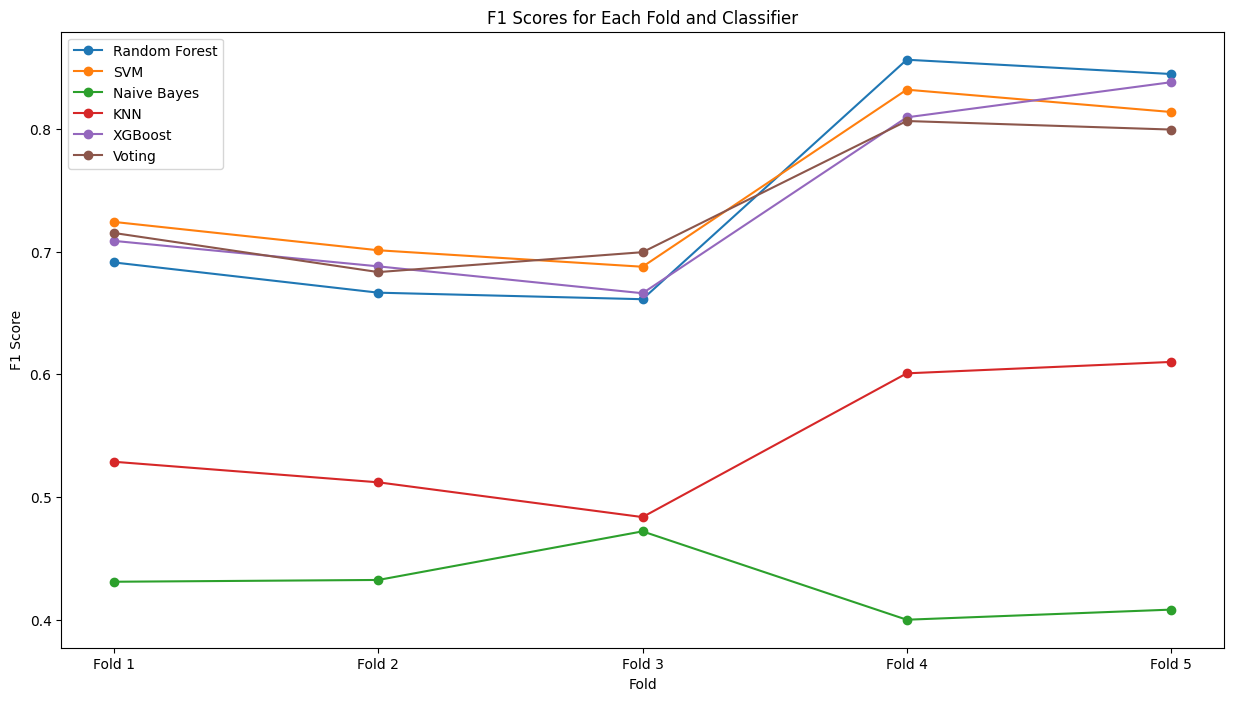

In [ ]:

plt.figure(figsize=(15, 8))

plt.plot(f1_scores_rf, marker='o', label='Random Forest')
plt.plot(f1_scores_svm, marker='o', label='SVM')
plt.plot(f1_scores_nb, marker='o', label='Naive Bayes')
plt.plot(f1_scores_knn, marker='o', label='KNN')
plt.plot(f1_scores_xgb, marker='o', label='XGBoost')
plt.plot(f1_scores_voting, marker='o', label='Voting')

plt.xlabel('Fold')
plt.xticks(ticks=range(5), labels=[f'Fold {i+1}' for i in range(5)])
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Fold and Classifier')
plt.legend()

plt.show()


In [ ]:
le.classes_

array(['Neutral', 'Opponents', 'Supporters'], dtype=object)

In [ ]:
from sklearn.metrics import classification_report
class_names = le.classes_

print("Random Forest:")
print(classification_report(y_test, rf_pred, target_names=class_names))

print("SVM:")
print(classification_report(y_test, svm_pred, target_names=class_names))

print("Naive Bayes:")
print(classification_report(y_test, nb_pred, target_names=class_names))

print('knn:')
print(classification_report(y_test, knn_pred, target_names=class_names))

print('XGboos:')
print(classification_report(y_test, xgb_pred, target_names=class_names))

print("Voting Classifier:")
print(classification_report(y_test, voting_pred, target_names=class_names))


Random Forest:
              precision    recall  f1-score   support

     Neutral       0.84      0.93      0.88       300
   Opponents       0.80      0.99      0.88       301
  Supporters       0.97      0.64      0.77       300

    accuracy                           0.85       901
   macro avg       0.87      0.85      0.84       901
weighted avg       0.87      0.85      0.84       901

SVM:
              precision    recall  f1-score   support

     Neutral       0.82      0.93      0.87       300
   Opponents       0.80      0.92      0.86       301
  Supporters       0.85      0.61      0.71       300

    accuracy                           0.82       901
   macro avg       0.83      0.82      0.81       901
weighted avg       0.82      0.82      0.81       901

Naive Bayes:
              precision    recall  f1-score   support

     Neutral       0.38      0.20      0.27       300
   Opponents       0.44      0.95      0.60       301
  Supporters       0.74      0.23      0.3

SAVE MODELS



# predict


In [ ]:
# Load the new data
df_en = pd.read_csv('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/data_en_clean.csv')
df_en

<ipython-input-7-88a25418f97e>:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_en = pd.read_csv('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/data_en_clean.csv')


,created_at,id_b36,author_idb36,id,original_text,metric_retweets,metric_likes,metric_replies,urls,media_keys,lang,author_id,event_id
0,2022-09-29 23:46:11+00:00,BYYBB1MAFSHX,FUFPH8,1.575630e+18,probably biggest lie pandemic 5g aggressively ...,1,6,1.0,NaN,NaN,en,9.581140e+08,6.0
1,2022-09-29 23:11:55+00:00,BYY8904O3K01,A7X3H7,1.575620e+18,"suspect person debating discussing bad faith ,...",0,1,1.0,NaN,NaN,en,6.179632e+08,6.0
2,2022-09-29 23:03:57+00:00,BYY7JFMBNRWG,T9NHU,1.575620e+18,"honest hope joke , people think spherical eart...",0,0,0.0,NaN,NaN,en,4.915922e+07,6.0
3,2022-09-29 22:37:02+00:00,BYY54YS6FUV4,69K60JXUN2TC,1.575620e+18,english teacher worked spain feb 2020 told cov...,0,1,0.0,https://twitter.com/strangepacks_/status/15754...,NaN,en,8.246840e+17,6.0
4,2022-09-29 22:34:59+00:00,BYY4YF38SY69,87GA8A27G2KG,1.575620e+18,"covid vaccines ? whole body 5g antennae , migh...",0,1,1.0,NaN,NaN,en,1.080220e+18,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326114,2020-04-06 06:35:04+00:00,9H2YE4BIA0OX,8N4TVKWUK45C,1.247050e+18,boomer terrorism,0,1,0.0,https://www.theverge.com/2020/4/4/21207927/5g-...,NaN,en,1.137560e+18,17.0
326115,2020-04-05 15:02:39+00:00,9H0N7QINA6TC,CICE5,1.246820e+18,calma !,0,0,0.0,https://www.theverge.com/2020/4/4/21207927/5g-...,NaN,en,2.101126e+07,17.0
326116,2020-04-05 09:24:45+00:00,9GZT2M5L5HC2,IHCF5,1.246730e+18,jesus ...,0,0,0.0,https://www.news.com.au/sport/sports-life/boxe...,NaN,en,3.104234e+07,17.0
326117,2020-04-05 03:38:15+00:00,9GYY5W27G8W0,1HLOA4F,1.246640e+18,5g equal corona,0,0,0.0,NaN,NaN,en,3.241112e+09,17.0


In [ ]:
# def clean_text(text):
#     # Remove URLs
#     text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
#     # Remove user @ references
#     text = re.sub(r'\@\w+','', text)

#     # Tokenize text and remove stop words
#     tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
#     text_tokens = tokenizer.tokenize(text)
#     text = [word for word in text_tokens if not word in stopwords.words('english')]
#     text = ' '.join(text)
#     return text

# # Clean the text
# df_en['original_text'] = df_en['original_text'].apply(clean_text)
# df_en.to_csv('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/data_en_clean.csv', index=False)


In [ ]:
df_en

,created_at,id_b36,author_idb36,id,original_text,metric_retweets,metric_likes,metric_replies,urls,media_keys,lang,author_id,event_id
0,2022-09-29 23:46:11+00:00,BYYBB1MAFSHX,FUFPH8,1.575630e+18,probably biggest lie pandemic 5g aggressively ...,1,6,1.0,NaN,NaN,en,9.581140e+08,6.0
1,2022-09-29 23:11:55+00:00,BYY8904O3K01,A7X3H7,1.575620e+18,"suspect person debating discussing bad faith ,...",0,1,1.0,NaN,NaN,en,6.179632e+08,6.0
2,2022-09-29 23:03:57+00:00,BYY7JFMBNRWG,T9NHU,1.575620e+18,"honest hope joke , people think spherical eart...",0,0,0.0,NaN,NaN,en,4.915922e+07,6.0
3,2022-09-29 22:37:02+00:00,BYY54YS6FUV4,69K60JXUN2TC,1.575620e+18,english teacher worked spain feb 2020 told cov...,0,1,0.0,https://twitter.com/strangepacks_/status/15754...,NaN,en,8.246840e+17,6.0
4,2022-09-29 22:34:59+00:00,BYY4YF38SY69,87GA8A27G2KG,1.575620e+18,"covid vaccines ? whole body 5g antennae , migh...",0,1,1.0,NaN,NaN,en,1.080220e+18,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326114,2020-04-06 06:35:04+00:00,9H2YE4BIA0OX,8N4TVKWUK45C,1.247050e+18,boomer terrorism,0,1,0.0,https://www.theverge.com/2020/4/4/21207927/5g-...,NaN,en,1.137560e+18,17.0
326115,2020-04-05 15:02:39+00:00,9H0N7QINA6TC,CICE5,1.246820e+18,calma !,0,0,0.0,https://www.theverge.com/2020/4/4/21207927/5g-...,NaN,en,2.101126e+07,17.0
326116,2020-04-05 09:24:45+00:00,9GZT2M5L5HC2,IHCF5,1.246730e+18,jesus ...,0,0,0.0,https://www.news.com.au/sport/sports-life/boxe...,NaN,en,3.104234e+07,17.0
326117,2020-04-05 03:38:15+00:00,9GYY5W27G8W0,1HLOA4F,1.246640e+18,5g equal corona,0,0,0.0,NaN,NaN,en,3.241112e+09,17.0


In [ ]:
!nvidia-smi


Fri Aug  4 13:48:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    49W / 300W |   2206MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ct_bert_tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
ct_bert_model = AutoModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2").to(device)
max_length=100
if torch.cuda.device_count() > 1:
    ct_bert_model = torch.nn.DataParallel(ct_bert_model)

sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
def truncate_text(text, max_length):
    tokens = text.split()[:max_length]
    return ' '.join(tokens)

batch_size = 128
ct_bert_embeddings = []
sbert_embeddings = []
from tqdm import tqdm

num_batches = len(df_en['original_text']) // batch_size + (len(df_en['original_text']) % batch_size != 0)

for i in tqdm(range(num_batches), desc="Embedding tweets", unit="batch"):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    tweets_batch = [str(text) for text in df_en['original_text'][start_idx:end_idx]]
    inputs = ct_bert_tokenizer(tweets_batch, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = ct_bert_model(**inputs)
    ct_bert_embeddings.extend(outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy())
    sbert_embeddings.extend(sbert_model.encode(tweets_batch, show_progress_bar=False))

embeddings = [np.concatenate((ct.flatten(), sb.flatten())) for ct, sb in zip(ct_bert_embeddings, sbert_embeddings)]
embeddings = np.vstack(embeddings)
np.save('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT-BERT2/embeddings_326en.npy', embeddings)


Embedding tweets: 100%|██████████| 2548/2548 [25:39<00:00,  1.66batch/s]


In [ ]:
torch.cuda.empty_cache()

In [ ]:
embeddings = np.load('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT BERT/embeddings_326en.npy')

pca = PCA(562)
reduced_embeddings = pca.fit_transform(embeddings)



In [ ]:
from joblib import load

model_path = ('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT BERT/fold_4_xgboost.joblib')
chosen_model = load(model_path)

predictions = chosen_model.predict(reduced_embeddings)
# np.save('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT-BERT2/predictionsrf.npy', predictions)

print("Predictions made on complete data and saved to file.")


Predictions made on complete data and saved to file.


In [ ]:
df_en['predicted_classification'] = predictions

print(df_en['predicted_classification'].value_counts())
csv_path = '/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT BERT/predicted_dataxgb_en.csv'
df_en.to_csv(csv_path, index=False)

2    183578
0     95914
1     46627
Name: predicted_classification, dtype: int64


In [ ]:
label_mapping = {
    0: "Neutral",
    1: "Opponents",
    2: "Supporters"
}

df_en = pd.read_csv("/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT BERT/predicted_dataxgb_en.csv")
df_en['predicted_classification'] = df_en['predicted_classification'].replace(label_mapping)

print(df_en['predicted_classification'].value_counts())
csv_path = '/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT BERT/predicted_dataxgb_en_last.csv'
df_en.to_csv(csv_path, index=False)


<ipython-input-35-be06bff282f2>:9: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_en = pd.read_csv("/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT BERT/predicted_dataxgb_en.csv")


Supporters    183578
Neutral        95914
Opponents      46627
Name: predicted_classification, dtype: int64


# visualszia

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


<ipython-input-31-40de79561893>:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT BERT/predicted_dataxgb_en.csv')


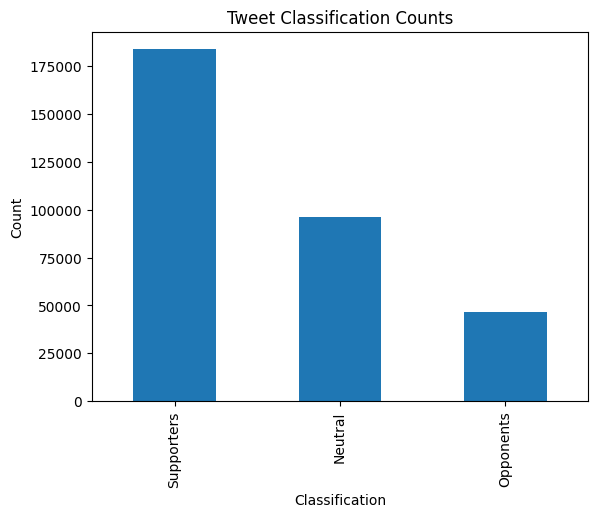

In [ ]:
# Read the data
df = pd.read_csv('/content/drive/MyDrive/פרוייקט גמר יקיר ומנגשה/BERT/CT BERT/predicted_dataxgb_en.csv')

# Count the number of tweets for each classification
classification_counts = df['predicted_classification'].value_counts()

# Plot the bar chart
classification_counts.plot(kind='bar')
plt.title('Tweet Classification Counts')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()


In [ ]:
df.to_csv("")

,created_at,id_b36,author_idb36,id,original_text,metric_retweets,metric_likes,metric_replies,urls,media_keys,lang,author_id,event_id,predicted_classification
0,2022-09-29 23:46:11+00:00,BYYBB1MAFSHX,FUFPH8,1.575630e+18,probably biggest lie pandemic 5g aggressively ...,1,6,1.0,NaN,NaN,en,9.581140e+08,6.0,Neutral
1,2022-09-29 23:11:55+00:00,BYY8904O3K01,A7X3H7,1.575620e+18,"suspect person debating discussing bad faith ,...",0,1,1.0,NaN,NaN,en,6.179632e+08,6.0,Opponents
2,2022-09-29 23:03:57+00:00,BYY7JFMBNRWG,T9NHU,1.575620e+18,"honest hope joke , people think spherical eart...",0,0,0.0,NaN,NaN,en,4.915922e+07,6.0,Opponents
3,2022-09-29 22:37:02+00:00,BYY54YS6FUV4,69K60JXUN2TC,1.575620e+18,english teacher worked spain feb 2020 told cov...,0,1,0.0,https://twitter.com/strangepacks_/status/15754...,NaN,en,8.246840e+17,6.0,Supporters
4,2022-09-29 22:34:59+00:00,BYY4YF38SY69,87GA8A27G2KG,1.575620e+18,"covid vaccines ? whole body 5g antennae , migh...",0,1,1.0,NaN,NaN,en,1.080220e+18,6.0,Supporters
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326114,2020-04-06 06:35:04+00:00,9H2YE4BIA0OX,8N4TVKWUK45C,1.247050e+18,boomer terrorism,0,1,0.0,https://www.theverge.com/2020/4/4/21207927/5g-...,NaN,en,1.137560e+18,17.0,Opponents
326115,2020-04-05 15:02:39+00:00,9H0N7QINA6TC,CICE5,1.246820e+18,calma !,0,0,0.0,https://www.theverge.com/2020/4/4/21207927/5g-...,NaN,en,2.101126e+07,17.0,Neutral
326116,2020-04-05 09:24:45+00:00,9GZT2M5L5HC2,IHCF5,1.246730e+18,jesus ...,0,0,0.0,https://www.news.com.au/sport/sports-life/boxe...,NaN,en,3.104234e+07,17.0,Neutral
326117,2020-04-05 03:38:15+00:00,9GYY5W27G8W0,1HLOA4F,1.246640e+18,5g equal corona,0,0,0.0,NaN,NaN,en,3.241112e+09,17.0,Neutral


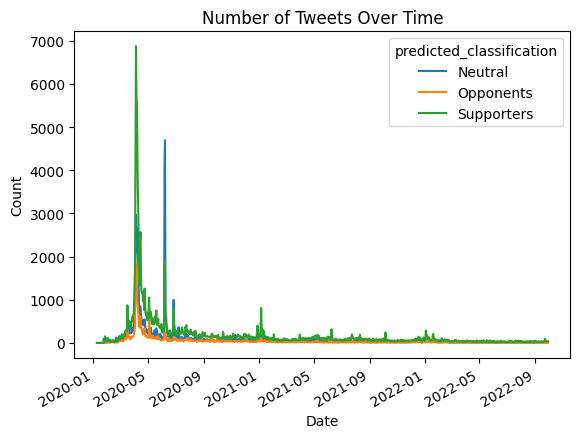

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df = df.dropna(subset=['created_at'])
time_series_data = df.resample('D', on='created_at')['predicted_classification'].value_counts().unstack().fillna(0)
time_series_data.plot()
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()
